This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Attenuation correction

In this example, we will compare different approaches to **constrain the gate-by-gate retrieval** of path-integrated attenuation.

## Introduction

Rainfall-induced attenuation is a major source of underestimation for radar-based precipitation estimation at C-band and X-band. Unconstrained forward gate-by-gate correction is known to be inherently unstable and thus not suited for unsupervised quality control procedures. Ideally, reference measurements (e.g. from microwave links) should be used to constrain gate-by-gate procedures. However, such attenuation references are usually not available. $\omega radlib$ provides a pragmatic approach to constrain gate-by-gate correction procedures, inspired by the work of [Kraemer et al., 2008](https://docs.wradlib.org/en/latest/bibliography.html#kraemer2008). It turned out that these procedures can effectively reduce the error introduced by attenuation, and, at the same time, minimize instability issues [(Jacobi et al., 2016)](https://docs.wradlib.org/en/latest/bibliography.html#jacobi2016).

In [1]:
import wradlib as wrl
import wradlib_data
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
import numpy as np

## The Example Event: June 2nd, 2008, SW-Germany

Let's have a look at the situation in South-West Germany on June 2nd, 2008, at 16:55 UTC, as observed by the DWD C-band radar on mount Feldberg.

The data can be read by the following lines and then visualized by [wradlib.vis.plot()](https://docs.wradlib.org/en/latest/generated/wradlib.vis.plot.html):

In [2]:
fpath = "dx/raa00-dx_10908-0806021655-fbg---bin.gz"
f = wradlib_data.DATASETS.fetch(fpath)
data, attrs = wrl.io.read_dx(f)

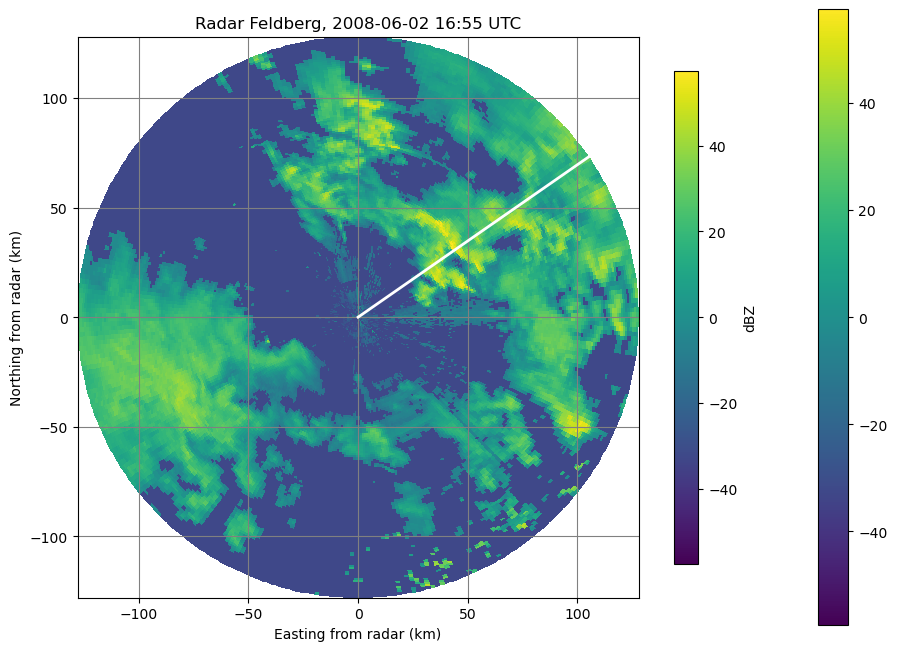

In [3]:
plt.figure(figsize=(10, 8))
da = wrl.georef.create_xarray_dataarray(data).wrl.georef.georeference()
cf = da.wrl.vis.plot(cmap="viridis")
plt.xlabel("Easting from radar (km)")
plt.ylabel("Northing from radar (km)")
plt.title("Radar Feldberg, 2008-06-02 16:55 UTC")
cb = plt.colorbar(cf, shrink=0.8)
cb.set_label("dBZ")
plt.plot([0, 105.6], [0, 73.4], "-", color="white", lw=2)
plt.xlim(-128, 128)
plt.ylim(-128, 128)
plt.grid(color="grey")

We see a set of convective cells with high rainfall intensity in the NE-sector of the Feldberg radar. Let us examine the reflectivity profile along **three beams which at azimuths 53-55 degree** (as marked by the white line in the PPI above).

In [4]:
# just a little helper function
def plot_beams(data, mybeams, sub=111):
    ax = fig.add_subplot(sub)
    labelsize = 13
    for beam in range(mybeams.start, mybeams.stop):
        plt.plot(data[beam], label="{0} deg".format(beam))
    plt.grid()
    plt.text(
        0.99,
        0.88,
        "Reflectivity along beams",
        horizontalalignment="right",
        transform=ax.transAxes,
        fontsize="large",
    )
    plt.xlabel("range (km)", fontsize="large")
    plt.ylabel("Reflectivity (dBZ)", fontsize="large")
    plt.legend(loc="upper left")
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.xlim(0, 128)

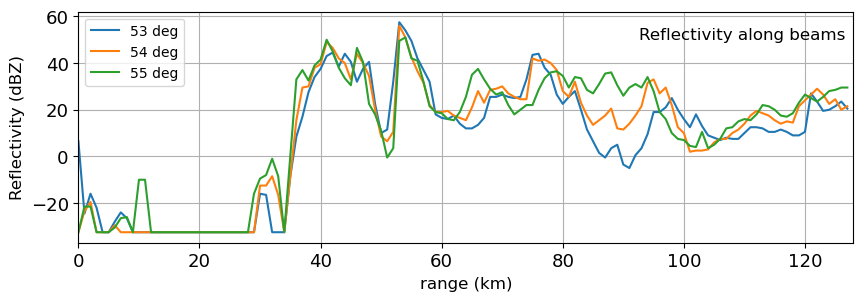

In [5]:
mybeams = slice(53, 56)
fig = plt.figure(figsize=(10, 3))
plot_beams(data, mybeams)

## Examining different attenuation correction procedures

### Hitschfeld and Bordan

Unconstrained gate-by-gate retrieval (1954)

First, we examine the behaviour of the "classical" unconstrained forward correction which is typically referred to [Hitschfeld et al., 1954](https://docs.wradlib.org/en/latest/bibliography.html#hitschfeld1954), although Hitschfeld and Bordan themselves rejected this approach. The Path Integrated Attenuation (PIA) according to this approach can be obtained as follows:

In [6]:
pia_hibo = wrl.atten.correct_attenuation_hb(
    data, coefficients=dict(a=8.0e-5, b=0.731, gate_length=1.0), mode="warn", thrs=59.0
)

corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


corrected signal over threshold (59.0)


In the coefficients dictionary, we can pass the power law parameters of the A(Z) relation as well as the gate length (in km). If we pass "warn" as the mode argument, we will obtain a warning log in case the corrected reflectivity exceeds the value of argument ``thrs`` (dBZ).

Plotting the result below the reflectivity profile, we obtain the following figure.  

In [7]:
# another little helper function
def plot_pia(pia, sub=111, title=None):
    ax = fig.add_subplot(sub)
    labelsize = 13
    plt.plot(pia.T)
    plt.grid()
    plt.ylim(0, 30)
    plt.ylabel("PIA (dB)", fontsize="large")
    plt.text(0.01, 0.88, title, transform=ax.transAxes, fontsize="large")
    ax.tick_params(axis="x", labelsize=labelsize)
    ax.tick_params(axis="y", labelsize=labelsize)
    plt.xlim(0, 128)

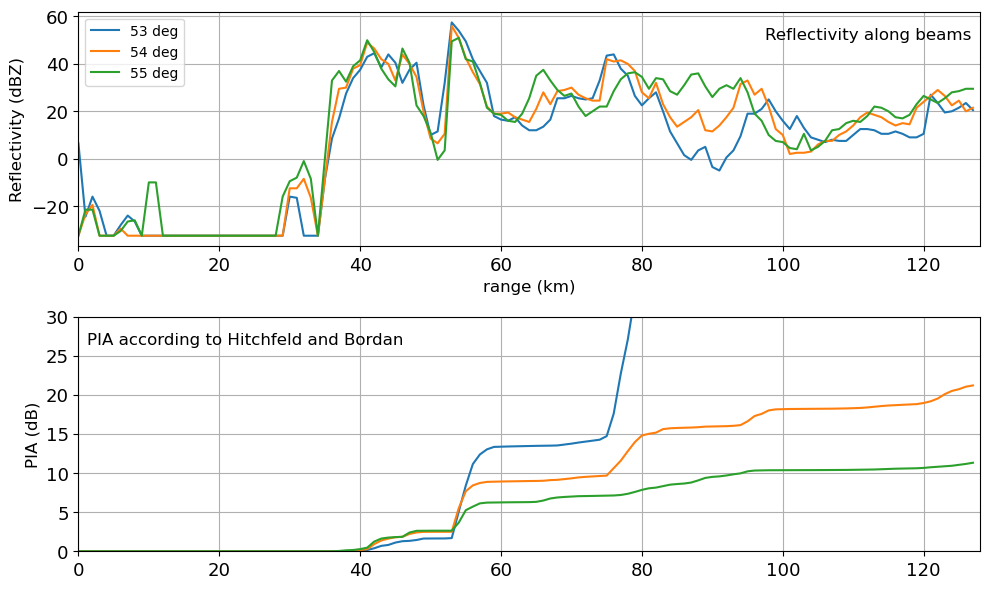

In [8]:
fig = plt.figure(figsize=(10, 6))
plot_beams(data, mybeams, 211)
plot_pia(pia_hibo[mybeams], 212, "PIA according to Hitchfeld and Bordan")
plt.tight_layout()

Apparently, slight differences in the reflectivity profile can cause a dramatic change in the behaviour. While at 54 and 55 degrees, the retrieval of PIA appears to be fairly stable, the profile of PIA for 53 degree demonstrates a case of instability.  

### Harrison
Harrison et.al. (2000): Cap PIA at a factor of two

[Harrison et al., 2000](https://docs.wradlib.org/en/latest/bibliography.html#harrison2000) suggested to simply cap PIA in case it would cause a correction of rainfall intensity by more than a factor of two. Depending on the parameters of the Z(R) relationship, that would correpond to PIA values between 4 and 5 dB (4.8 dB if we assume exponent b=1.6).

One way to implement this approach would be the following:

In [9]:
pia_harrison = wrl.atten.correct_attenuation_hb(
    data, coefficients=dict(a=4.57e-5, b=0.731, gate_length=1.0), mode="warn", thrs=59.0
)
pia_harrison[pia_harrison > 4.8] = 4.8

And the results would look like this:

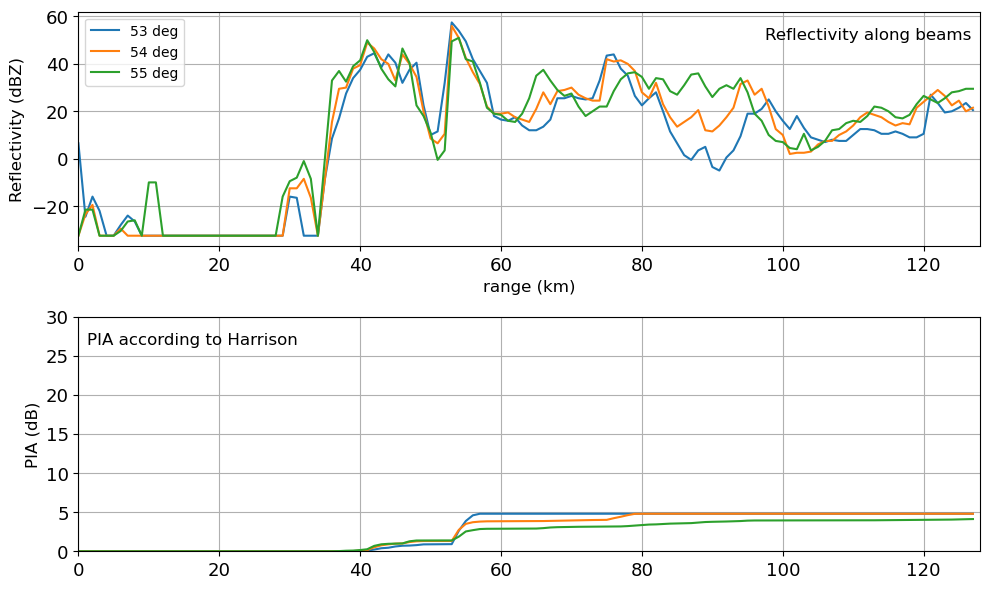

In [10]:
fig = plt.figure(figsize=(10, 6))

mybeams = slice(53, 56)
labelsize = 13

plot_beams(data, mybeams, 211)
plot_pia(pia_harrison[mybeams], 212, "PIA according to Harrison")
plt.tight_layout()

### Kraemer
Kraemer et al. (2008): Iterative estimation of A(Z) relationsip

[Kraemer et al., 2008](https://docs.wradlib.org/en/latest/bibliography.html#kraemer2008) suggested to iteratively determine the power law parameters of the A(Z). In particular, the power law coefficient is interatively decreased until the attenuation correction does not lead to reflectivity values above a given threshold (Kraemer suggested 59 dBZ). Using $\omega radlib$, this would be called by using the function [wradlib.atten.correct_attenuation_constrained()](https://docs.wradlib.org/en/latest/generated/wradlib.atten.correct_attenuation_constrained.html) with a specific ``constraints`` argument:

In [11]:
pia_kraemer = wrl.atten.correct_attenuation_constrained(
    data,
    a_max=1.67e-4,
    a_min=2.33e-5,
    n_a=100,
    b_max=0.7,
    b_min=0.65,
    n_b=6,
    gate_length=1.0,
    constraints=[wrl.atten.constraint_dbz],
    constraint_args=[[59.0]],
)

In brief, this call specifies ranges of the power parameters a and b of the A(Z) relation. Beginning from the maximum values (``a_max`` and ``b_max``), the function searches for values of ``a`` and ``b`` so that the corrected reflectivity will not exceed the dBZ constraint of 59 dBZ. Compared to the previous results, the corresponding profiles of PIA look like this:   

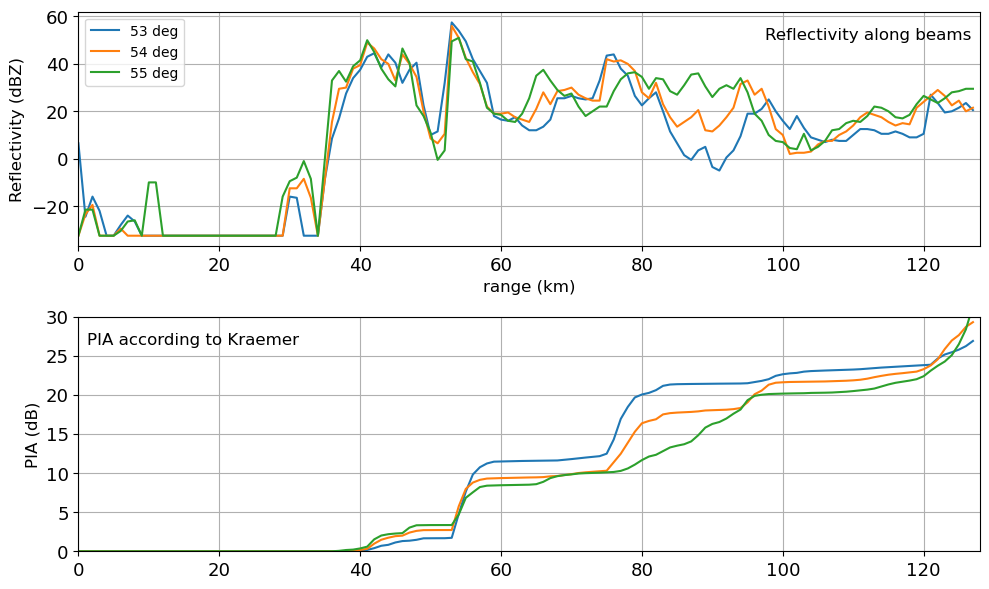

In [12]:
fig = plt.figure(figsize=(10, 6))
plot_beams(data, mybeams, 211)
plot_pia(pia_kraemer[mybeams], 212, "PIA according to Kraemer")
plt.tight_layout()

### Modified Kraemer 
Generalised Kraemer procedure: adding additional constraints 

The function [wradlib.atten.correct_attenuation_constrained()](https://docs.wradlib.org/en/latest/generated/wradlib.atten.correct_attenuation_constrained.html) allows us to pass any kind of constraint function or lists of constraint functions via the argument ``constraints``. The arguments of these functions are passed via a nested list as argument ``constraint_args``. For example, [Jacobi et al., 2016](https://docs.wradlib.org/en/latest/bibliography.html#jacobi2016) suggested to constrain *both* the corrected reflectivity (by a maximum of 59 dBZ) *and* the resulting path-intgrated attenuation PIA (by a maximum of 20 dB):

In [13]:
pia_mkraemer = wrl.atten.correct_attenuation_constrained(
    data,
    a_max=1.67e-4,
    a_min=2.33e-5,
    n_a=100,
    b_max=0.7,
    b_min=0.65,
    n_b=6,
    gate_length=1.0,
    constraints=[wrl.atten.constraint_dbz, wrl.atten.constraint_pia],
    constraint_args=[[59.0], [20.0]],
)

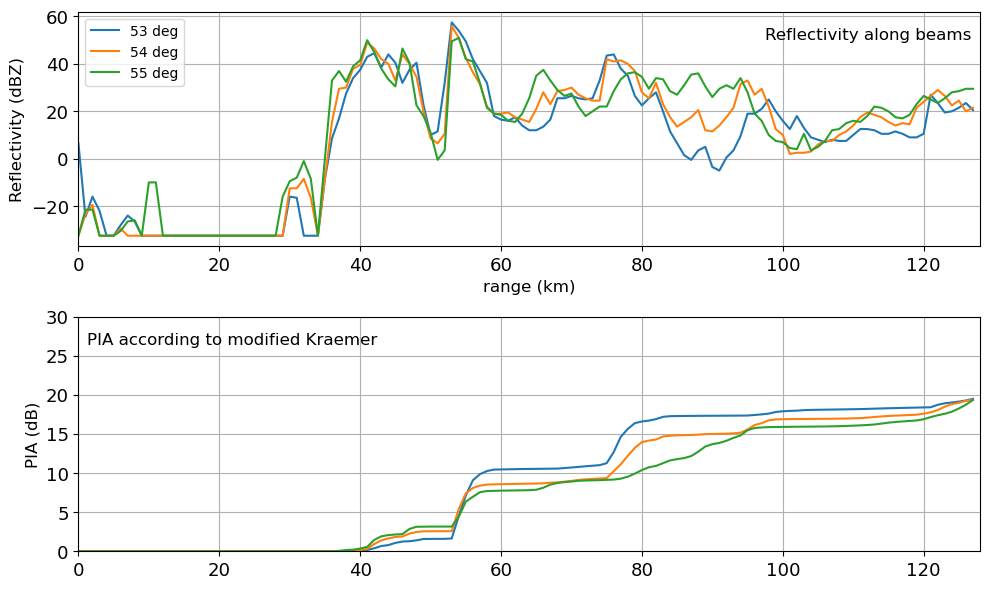

In [14]:
fig = plt.figure(figsize=(10, 6))
plot_beams(data, mybeams, 211)
plot_pia(pia_mkraemer[mybeams], 212, "PIA according to modified Kraemer")
plt.tight_layout()

## Comparison of all Methods

Plotting all of the above methods ([Hitschfeld and Bordan](#Hitschfeld-and-Bordan), [Harrison](#Harrison), [Kraemer](#Kraemer), [Modified Kraemer](#Modified-Kraemer) allows for a better comparison of their behaviour. Please refer to [Jacobi et al., 2016](https://docs.wradlib.org/en/latest/bibliography.html#jacobi2016) for an in-depth discussion of this example.

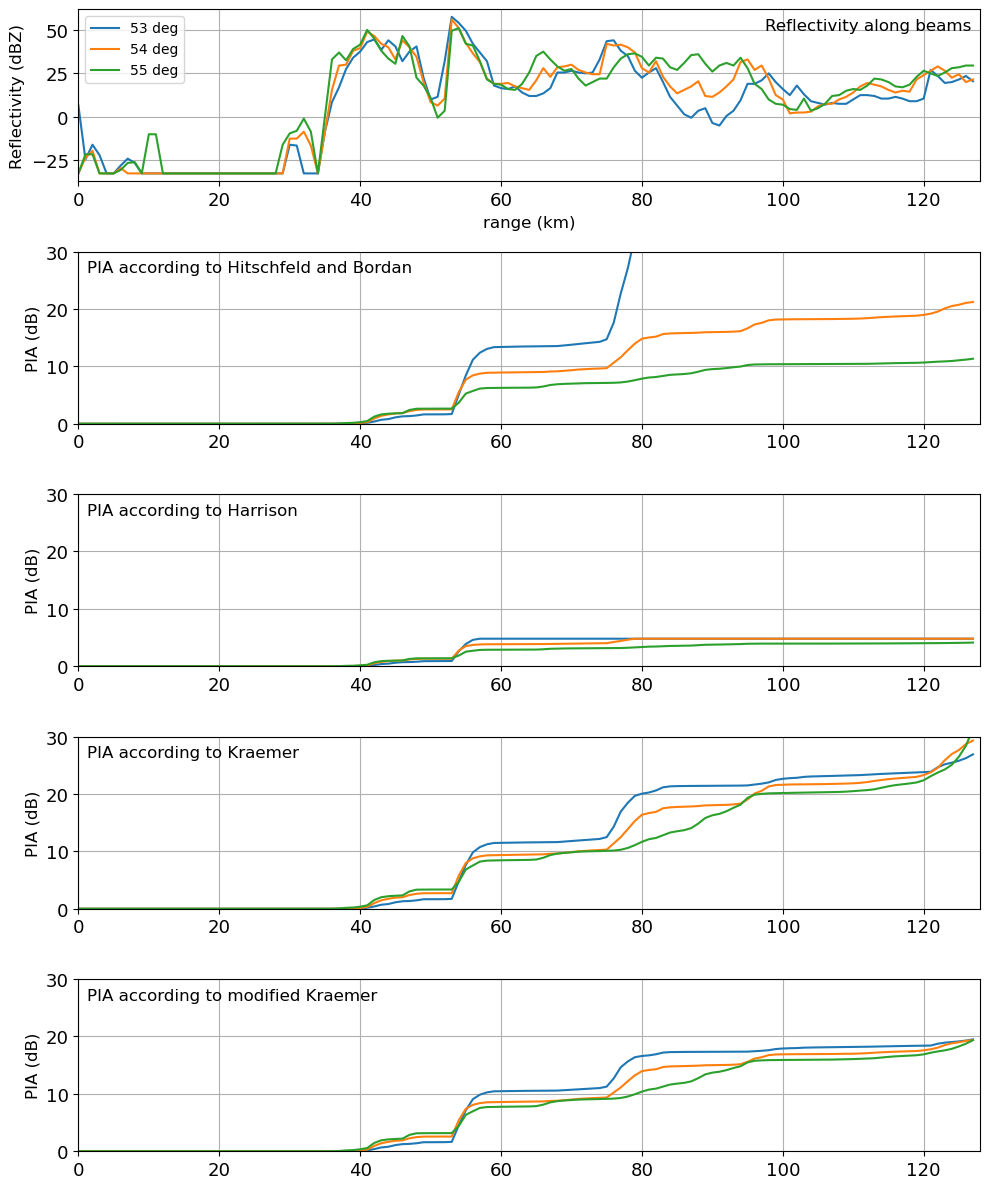

In [15]:
fig = plt.figure(figsize=(10, 12))

plot_beams(data, mybeams, 511)
plot_pia(pia_hibo[mybeams], 512, "PIA according to Hitschfeld and Bordan")
plot_pia(pia_harrison[mybeams], 513, "PIA according to Harrison")
plot_pia(pia_kraemer[mybeams], 514, "PIA according to Kraemer")
plot_pia(pia_mkraemer[mybeams], 515, "PIA according to modified Kraemer")
plt.tight_layout()